# Rossmann Sales Pipeline
A clean end-to-end workflow: data overview, EDA, feature engineering, model preparation, training, and submission.

## 0) Setup and Data Loading

In [10]:
# 0.1 Imports
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 0.2 Global settings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

# 0.3 Dataset paths
DATA_DIR = Path(r"C:\bootcamp\Rossman-final-project\Datasets")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
STORE_PATH = DATA_DIR / "store.csv"

# 0.4 Load raw datasets
train_raw = pd.read_csv(TRAIN_PATH, low_memory=False)
test_raw = pd.read_csv(TEST_PATH, low_memory=False)
store = pd.read_csv(STORE_PATH, low_memory=False)

# 0.5 Parse date columns
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

# 0.6 Quick shape check
print('train_raw:', train_raw.shape)
print('test_raw :', test_raw.shape)
print('store    :', store.shape)

train_raw: (1017209, 9)
test_raw : (41088, 8)
store    : (1115, 10)


## 1) Data Overview

In [ ]:
# 1.1 Preview training dataset
display(train_raw.head())

# 1.2 Dataset size summary
overview = pd.DataFrame({
    'rows': [len(train_raw), len(test_raw), len(store)],
    'cols': [train_raw.shape[1], test_raw.shape[1], store.shape[1]],
}, index=['train_raw', 'test_raw', 'store'])
display(overview)

# 1.3 Missing-value diagnostics (train)
train_nan = pd.DataFrame({
    'NaN_Count': train_raw.isna().sum(),
    'NaN_Pct': (train_raw.isna().sum() / len(train_raw) * 100).round(2)
}).sort_values('NaN_Count', ascending=False)

# 1.4 Missing-value diagnostics (store)
store_nan = pd.DataFrame({
    'NaN_Count': store.isna().sum(),
    'NaN_Pct': (store.isna().sum() / len(store) * 100).round(2)
}).sort_values('NaN_Count', ascending=False)

# 1.5 Display non-empty NaN summaries
print('Train NaN columns:')
display(train_nan[train_nan['NaN_Count'] > 0])
print('Store NaN columns:')
display(store_nan[store_nan['NaN_Count'] > 0])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,rows,cols
train_raw,1017209,9
test_raw,41088,8
store,1115,10


Train NaN columns:


,NaN_Count,NaN_Pct


Store NaN columns:


,NaN_Count,NaN_Pct
PromoInterval,544,48.79
Promo2SinceYear,544,48.79
Promo2SinceWeek,544,48.79
CompetitionOpenSinceYear,354,31.75
CompetitionOpenSinceMonth,354,31.75
CompetitionDistance,3,0.27


## 2) Exploratory Data Analysis (Insights + Graphics)

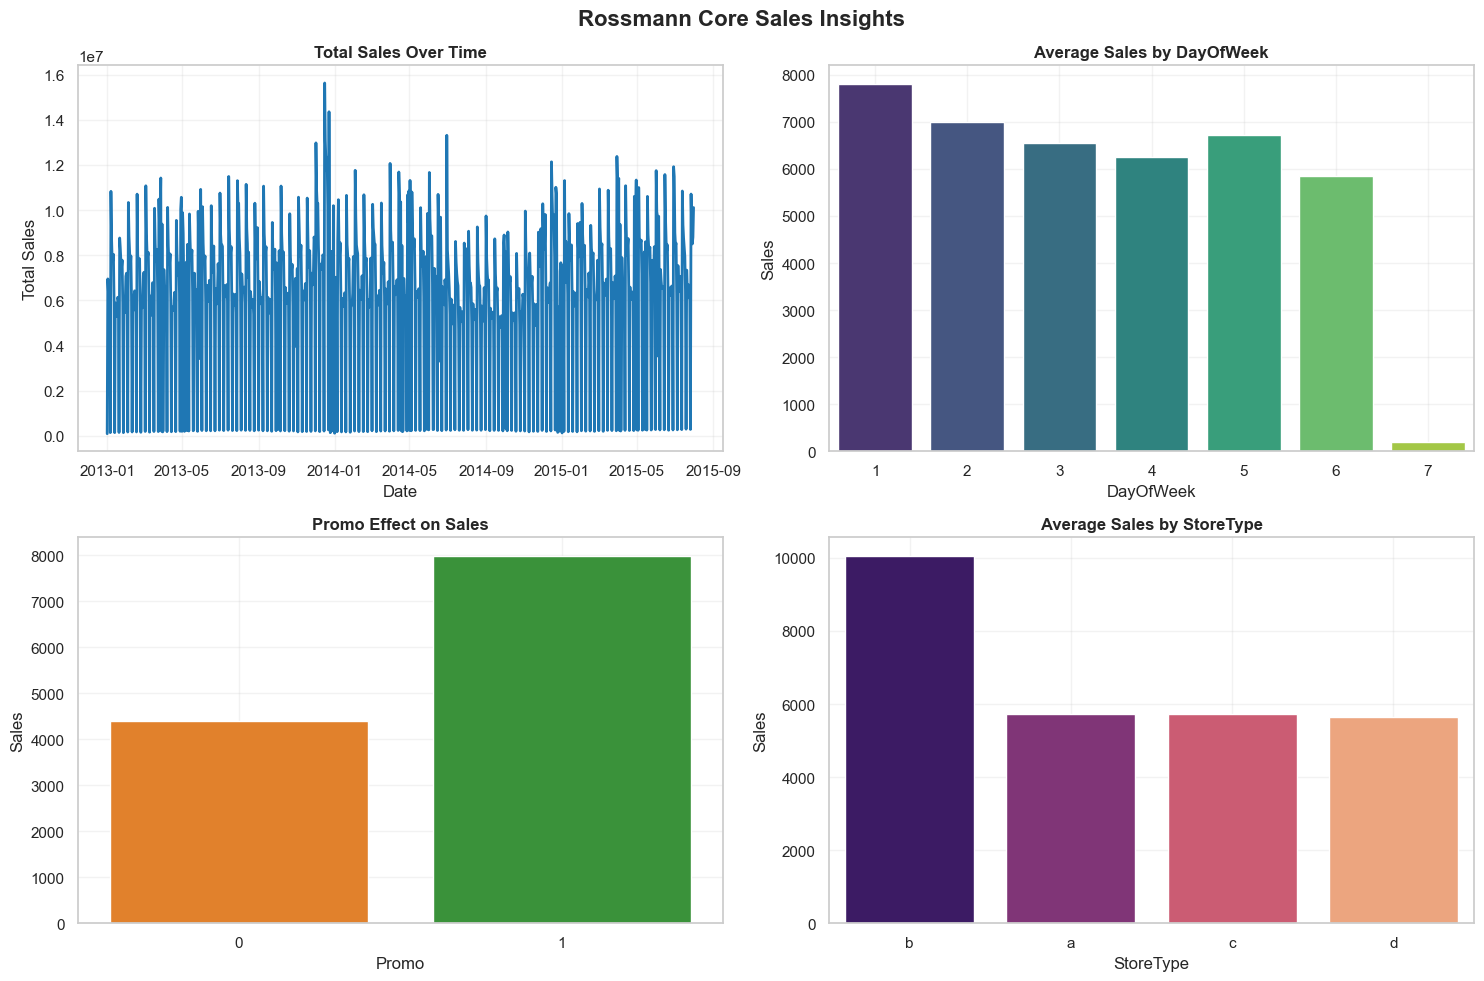

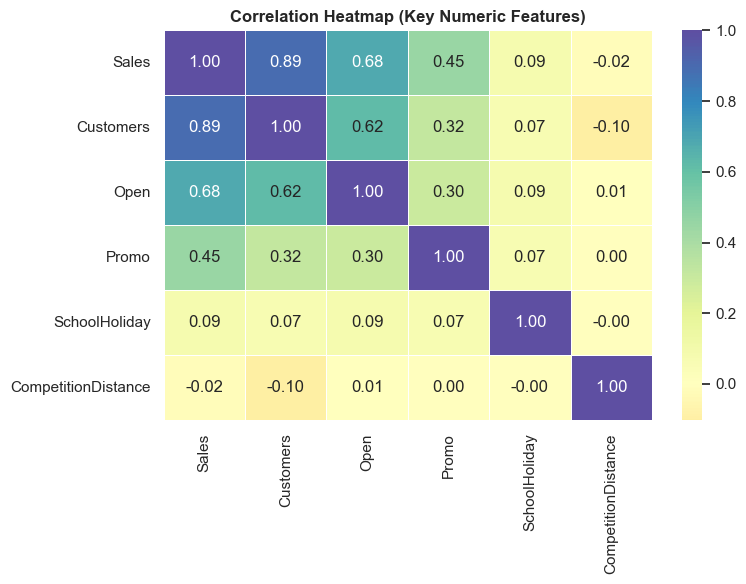

In [16]:
# 2.1 Merge train with store info for EDA
train_eda = train_raw.merge(store, on='Store', how='left')

# 2.2 Daily total sales trend
sales_daily = train_eda.groupby('Date', as_index=False)['Sales'].sum()

# 2.3 Core business insight plots (colorful + annotated)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rossmann Core Sales Insights', fontsize=16, fontweight='bold')

# Trend over time
sns.lineplot(data=sales_daily, x='Date', y='Sales', color='#1f77b4', linewidth=2, ax=axes[0, 0])
axes[0, 0].set_title('Total Sales Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')

# Day of week effect
dow_avg = train_eda.groupby('DayOfWeek', as_index=False)['Sales'].mean()
sns.barplot(data=dow_avg, x='DayOfWeek', y='Sales', palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Average Sales by DayOfWeek', fontweight='bold')

# Promo uplift
promo_avg = train_eda.groupby('Promo', as_index=False)['Sales'].mean()
sns.barplot(data=promo_avg, x='Promo', y='Sales', palette=['#ff7f0e', '#2ca02c'], ax=axes[1, 0])
axes[1, 0].set_title('Promo Effect on Sales', fontweight='bold')

# Store type effect
storetype_avg = train_eda.groupby('StoreType', as_index=False)['Sales'].mean().sort_values('Sales', ascending=False)
sns.barplot(data=storetype_avg, x='StoreType', y='Sales', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Average Sales by StoreType', fontweight='bold')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

# 2.4 Correlation on key numeric features
corr_cols = ['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance']
corr_df = train_eda[corr_cols].copy()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df.corr(numeric_only=True),
    annot=True,
    fmt='.2f',
    cmap='Spectral',
    center=0,
    linewidths=0.5,
)
plt.title('Correlation Heatmap (Key Numeric Features)', fontweight='bold')
plt.tight_layout()
plt.show()

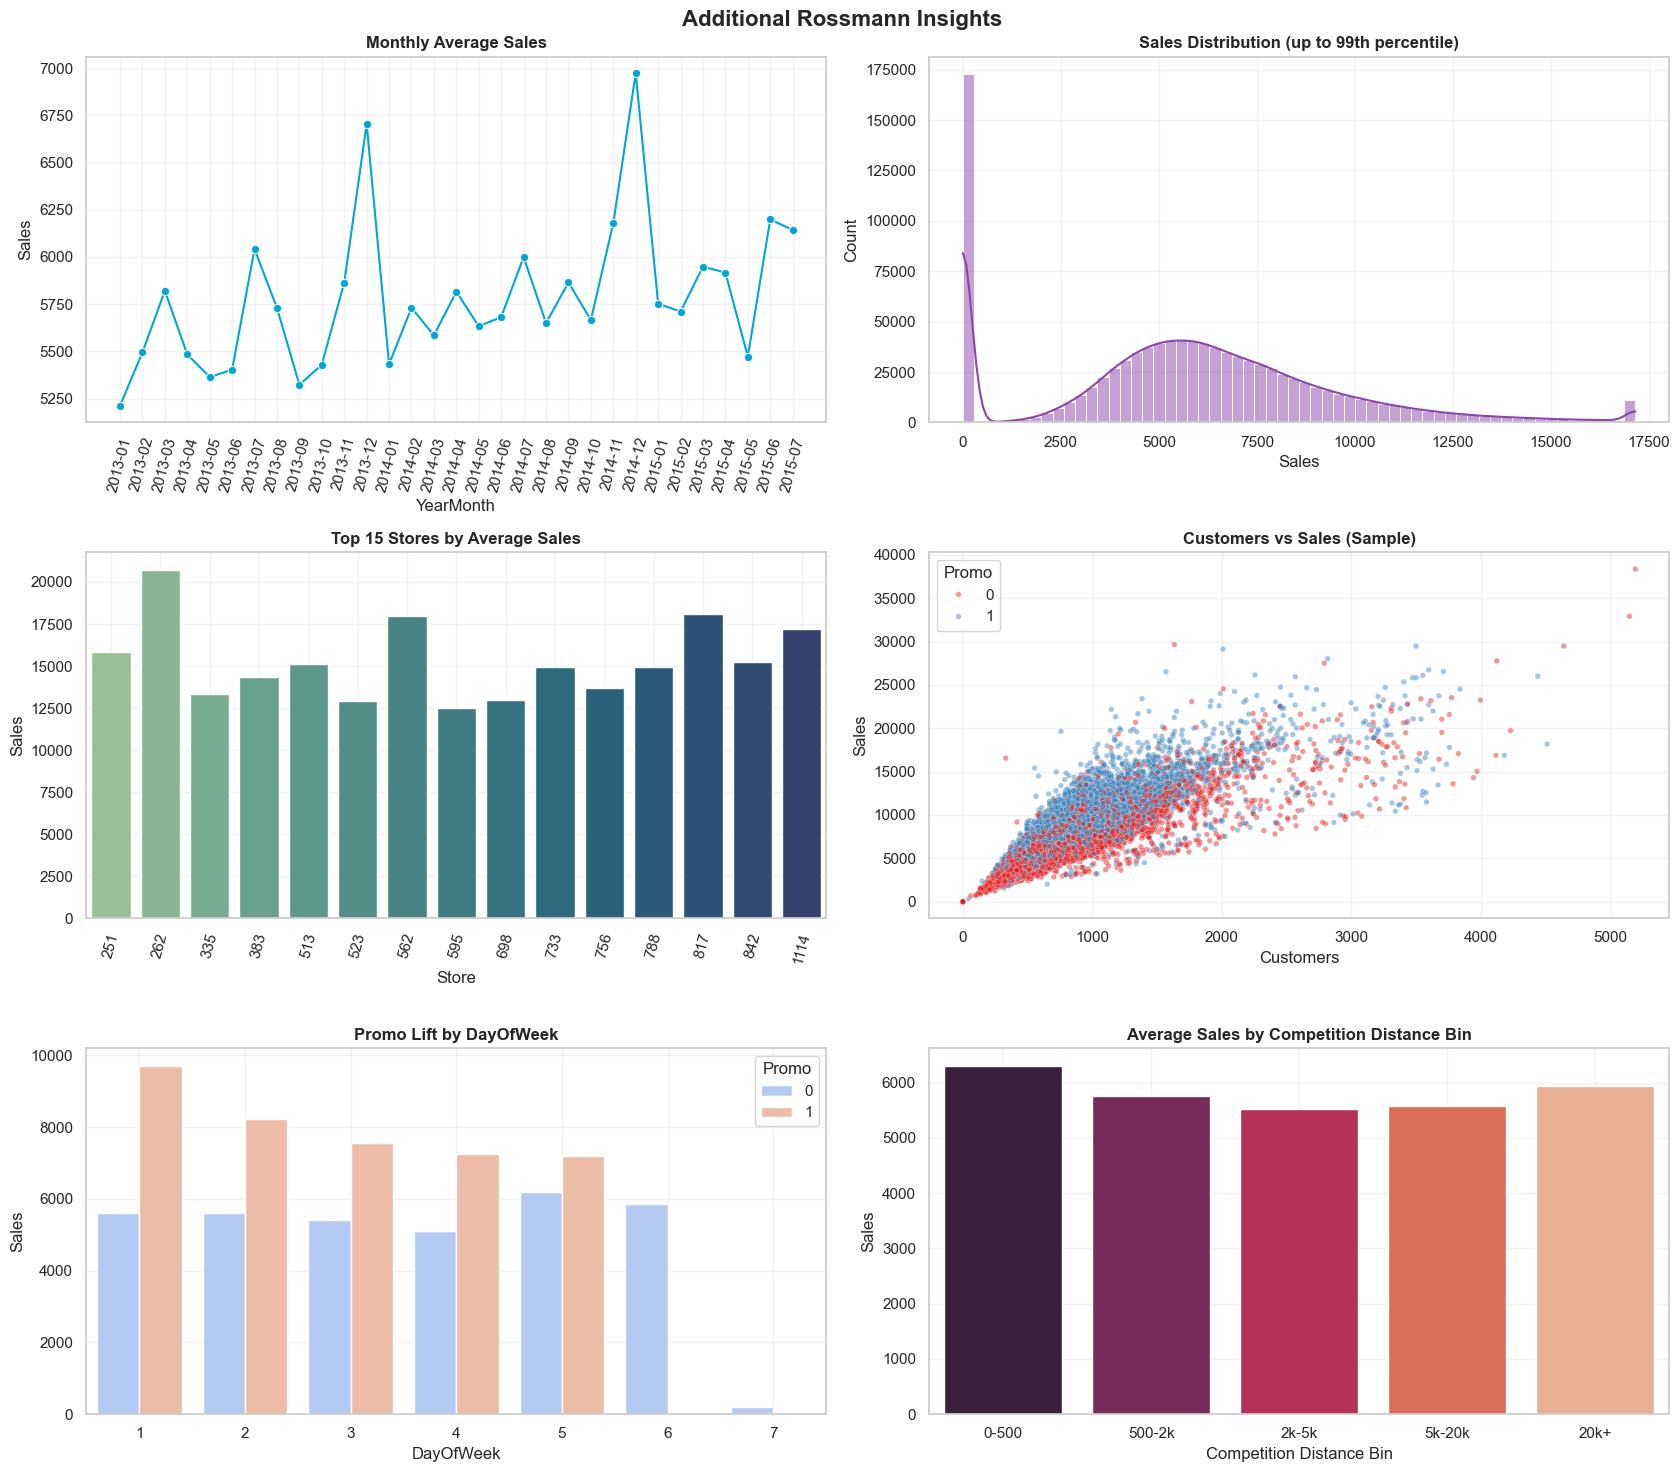

In [17]:
# Additional EDA visuals (more insightful)
eda = train_eda.copy()
eda['YearMonth'] = eda['Date'].dt.to_period('M').astype(str)

# 1) Monthly average sales
monthly_sales = eda.groupby('YearMonth', as_index=False)['Sales'].mean()

# 2) Sales distribution (capped for readability)
sales_cap = eda['Sales'].clip(upper=eda['Sales'].quantile(0.99))

# 3) Top stores by average sales
top_store_sales = (
    eda.groupby('Store', as_index=False)['Sales']
    .mean()
    .sort_values('Sales', ascending=False)
    .head(15)
)

# 4) Customers vs Sales sample (for speed and visibility)
scatter_sample = eda[['Customers', 'Sales', 'Promo']].dropna().sample(n=min(30000, len(eda)), random_state=42)

# 5) Promo uplift by day of week
promo_dow = eda.groupby(['DayOfWeek', 'Promo'], as_index=False)['Sales'].mean()

# 6) Competition distance bins
eda['CompDistBin'] = pd.cut(
    eda['CompetitionDistance'],
    bins=[0, 500, 2000, 5000, 20000, np.inf],
    labels=['0-500', '500-2k', '2k-5k', '5k-20k', '20k+']
)
comp_bin_sales = eda.groupby('CompDistBin', as_index=False)['Sales'].mean()

fig, axes = plt.subplots(3, 2, figsize=(17, 15))
fig.suptitle('Additional Rossmann Insights', fontsize=16, fontweight='bold')

sns.lineplot(data=monthly_sales, x='YearMonth', y='Sales', marker='o', color='#00a6d6', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Average Sales', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=75)

sns.histplot(sales_cap, bins=60, kde=True, color='#8e44ad', ax=axes[0, 1])
axes[0, 1].set_title('Sales Distribution (up to 99th percentile)', fontweight='bold')
axes[0, 1].set_xlabel('Sales')

sns.barplot(data=top_store_sales, x='Store', y='Sales', palette='crest', ax=axes[1, 0])
axes[1, 0].set_title('Top 15 Stores by Average Sales', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=75)

sns.scatterplot(data=scatter_sample, x='Customers', y='Sales', hue='Promo', palette='Set1', alpha=0.45, s=16, ax=axes[1, 1])
axes[1, 1].set_title('Customers vs Sales (Sample)', fontweight='bold')

sns.barplot(data=promo_dow, x='DayOfWeek', y='Sales', hue='Promo', palette='coolwarm', ax=axes[2, 0])
axes[2, 0].set_title('Promo Lift by DayOfWeek', fontweight='bold')

sns.barplot(data=comp_bin_sales, x='CompDistBin', y='Sales', palette='rocket', ax=axes[2, 1])
axes[2, 1].set_title('Average Sales by Competition Distance Bin', fontweight='bold')
axes[2, 1].set_xlabel('Competition Distance Bin')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

## 3) Data Engineering + Feature Engineering

In [ ]:
# 3.1 Core feature-engineering function
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # 3.1.1 Work on a copy
    d = df.copy()

    # 3.1.2 Date-based features
    d['Date'] = pd.to_datetime(d['Date'])
    d['Year'] = d['Date'].dt.year
    d['Month'] = d['Date'].dt.month
    d['Day'] = d['Date'].dt.day
    d['WeekOfYear'] = d['Date'].dt.isocalendar().week.astype(int)
    d['DayOfYear'] = d['Date'].dt.dayofyear
    d['IsMonthStart'] = d['Date'].dt.is_month_start.astype(int)
    d['IsMonthEnd'] = d['Date'].dt.is_month_end.astype(int)
    d['IsWeekend'] = d['DayOfWeek'].isin([6, 7]).astype(int)

    # 3.1.3 Competition features
    comp_date = pd.to_datetime(
        dict(
            year=d['CompetitionOpenSinceYear'].fillna(1900).astype(int),
            month=d['CompetitionOpenSinceMonth'].fillna(1).astype(int),
            day=1,
        ),
        errors='coerce'
    )
    d['CompMonthsSinceOpen'] = (
        (d['Date'].dt.year - comp_date.dt.year) * 12 + (d['Date'].dt.month - comp_date.dt.month)
    ).astype(float)
    d['CompMonthsSinceOpen'] = d['CompMonthsSinceOpen'].clip(lower=0)
    d['CompetitionActive'] = (d['CompMonthsSinceOpen'] > 0).astype(int)

    # 3.1.4 Promo2 timing features
    promo2_start = pd.to_datetime(
        d['Promo2SinceYear'].fillna(1900).astype(int).astype(str)
        + '-W' + d['Promo2SinceWeek'].fillna(1).astype(int).astype(str)
        + '-1',
        format='%G-W%V-%u',
        errors='coerce'
    )
    d['Promo2WeeksSinceStart'] = ((d['Date'] - promo2_start).dt.days / 7.0).astype(float)
    d['Promo2WeeksSinceStart'] = d['Promo2WeeksSinceStart'].clip(lower=0).fillna(0)

    # 3.1.5 Ensure holiday is categorical text
    d['StateHoliday'] = d['StateHoliday'].astype(str)

    return d

# 3.2 Merge base datasets
train_fe = train_raw.merge(store, on='Store', how='left')
test_fe = test_raw.merge(store, on='Store', how='left')

# 3.3 Apply engineered features
train_fe = add_features(train_fe)
test_fe = add_features(test_fe)

# 3.4 Keep only open stores and positive sales for training
train_fe = train_fe[(train_fe['Open'] == 1) & (train_fe['Sales'] > 0)].copy()

# 3.5 Shape check
print('train_fe shape:', train_fe.shape)
print('test_fe shape :', test_fe.shape)

train_fe shape: (844338, 29)
test_fe shape : (41088, 28)


In [12]:
# 3.1-L Legacy advanced features from the previous pipeline
from scipy.stats import skew, kurtosis
from sklearn.linear_model import Ridge


# 3.1-L.1 Harmonic mean helper for positive sales
def harmonic_mean(x):
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return len(x) / np.sum(1.0 / x)


# 3.1-L.2 Compute rich historical summary stats
def compute_recent_stats(history, prefix):
    arr = history.values
    if len(arr) == 0:
        return {
            f"{prefix}_mean": np.nan,
            f"{prefix}_median": np.nan,
            f"{prefix}_hmean": np.nan,
            f"{prefix}_std": np.nan,
            f"{prefix}_skew": np.nan,
            f"{prefix}_kurt": np.nan,
            f"{prefix}_p10": np.nan,
            f"{prefix}_p90": np.nan,
        }

    return {
        f"{prefix}_mean": np.mean(arr),
        f"{prefix}_median": np.median(arr),
        f"{prefix}_hmean": harmonic_mean(arr),
        f"{prefix}_std": np.std(arr),
        f"{prefix}_skew": skew(arr) if len(arr) > 2 else 0,
        f"{prefix}_kurt": kurtosis(arr) if len(arr) > 3 else 0,
        f"{prefix}_p10": np.percentile(arr, 10),
        f"{prefix}_p90": np.percentile(arr, 90),
    }


# 3.1-L.3 Build rolling-history features by store and context
def build_recent_features(train_df, target_df, windows_days=[90, 180, 365, 730]):
    train_df = train_df.copy()
    target_df = target_df.copy()
    features = []

    for _, row in target_df.iterrows():
        store_id = row['Store']
        date = row['Date']
        store_hist = train_df[(train_df['Store'] == store_id) & (train_df['Date'] < date)]

        row_feats = {}
        for w in windows_days:
            start_date = date - pd.Timedelta(days=w)
            hist_window = store_hist[store_hist['Date'] >= start_date]

            row_feats.update(compute_recent_stats(hist_window['Sales'], f'hist_{w}d'))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['DayOfWeek'] == row['DayOfWeek']]['Sales'],
                f'dow_{w}d'
            ))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['Promo'] == row['Promo']]['Sales'],
                f'promo_{w}d'
            ))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['StateHoliday'] == row['StateHoliday']]['Sales'],
                f'holiday_{w}d'
            ))

        features.append(row_feats)

    feat_df = pd.DataFrame(features, index=target_df.index)
    return pd.concat([target_df, feat_df], axis=1)


# 3.1-L.4 Build store-level trend signal using ridge regression
def build_trend_features(train_df, target_df, lookback_days=365):
    train_df = train_df.copy()
    target_df = target_df.copy()
    trend_preds = []

    for _, row in target_df.iterrows():
        store_id = row['Store']
        date = row['Date']

        store_hist = train_df[(train_df['Store'] == store_id) & (train_df['Date'] < date)]
        store_hist = store_hist[store_hist['Date'] >= date - pd.Timedelta(days=lookback_days)]

        if len(store_hist) < 50:
            trend_preds.append(np.nan)
            continue

        trend_X = pd.get_dummies(
            store_hist[['DayOfYear', 'Promo', 'DayOfWeek']],
            columns=['DayOfWeek'],
            drop_first=True
        )
        trend_y = np.log1p(store_hist['Sales'].values)

        trend_model = Ridge(alpha=1.0)
        trend_model.fit(trend_X, trend_y)

        X_pred = pd.get_dummies(pd.DataFrame([{
            'DayOfYear': row['DayOfYear'],
            'Promo': row['Promo'],
            'DayOfWeek': row['DayOfWeek']
        }]), columns=['DayOfWeek'], drop_first=True)

        X_pred = X_pred.reindex(columns=trend_X.columns, fill_value=0)
        trend_preds.append(trend_model.predict(X_pred)[0])

    target_df['TrendLogSales_1y'] = trend_preds
    return target_df


## 4) Model Preparation

In [13]:
# 4.1 Define prediction target
target = 'Sales'

# 4.2 Build base training and test matrices
drop_cols = ['Sales', 'Customers', 'Date']
X = train_fe.drop(columns=[c for c in drop_cols if c in train_fe.columns])
y = np.log1p(train_fe[target].astype(float))
X_test = test_fe.drop(columns=['Date'])

# 4.3 Time-based split (last 6 weeks for validation)
cutoff = train_fe['Date'].max() - pd.Timedelta(weeks=6)
train_idx = train_fe['Date'] < cutoff
valid_idx = train_fe['Date'] >= cutoff

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()
X_valid = X.loc[valid_idx].copy()
y_valid = y.loc[valid_idx].copy()

# 4.4 Identify categorical vs numeric features
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
categorical_cols = [c for c in categorical_cols if c in X_train.columns]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# 4.5 Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]), categorical_cols),
    ],
    remainder='drop'
)

# 4.6 Split check
print('Train split:', X_train.shape)
print('Valid split:', X_valid.shape)

Train split: (802942, 26)
Valid split: (41396, 26)


## 5) Model Training and Validation

In [14]:
# 5.1 RMSPE metric for Rossmann evaluation
def rmspe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# 5.2 Choose model (XGBoost preferred, fallback to RandomForest)
try:
    from xgboost import XGBRegressor
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )
    model_name = 'XGBRegressor'
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )
    model_name = 'RandomForestRegressor (fallback)'

# 5.3 Full training pipeline (preprocess + model)
pipe = Pipeline([
    ('prep', preprocessor),
    ('model', model),
])

# 5.4 Train on training split
pipe.fit(X_train, y_train)

# 5.5 Predict on train and validation splits
train_pred_log = pipe.predict(X_train)
valid_pred_log = pipe.predict(X_valid)

train_pred = np.expm1(train_pred_log)
valid_pred = np.expm1(valid_pred_log)

y_train_true = np.expm1(y_train)
y_valid_true = np.expm1(y_valid)

# 5.6 Train-set metrics (accuracy proxy + errors)
train_r2 = r2_score(y_train_true, train_pred)
train_rmspe = rmspe(y_train_true, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_true, train_pred))
train_mae = mean_absolute_error(y_train_true, train_pred)

# 5.7 Validation metrics
valid_r2 = r2_score(y_valid_true, valid_pred)
valid_rmspe = rmspe(y_valid_true, valid_pred)
valid_rmse = np.sqrt(mean_squared_error(y_valid_true, valid_pred))
valid_mae = mean_absolute_error(y_valid_true, valid_pred)

# 5.8 Report metrics
print('Model:', model_name)
print('\nTrain metrics:')
print(f'  R² (accuracy proxy): {train_r2:.5f}')
print(f'  RMSPE             : {train_rmspe:.5f}')
print(f'  RMSE              : {train_rmse:,.2f}')
print(f'  MAE               : {train_mae:,.2f}')

print('\nValidation metrics:')
print(f'  R² (accuracy proxy): {valid_r2:.5f}')
print(f'  RMSPE             : {valid_rmspe:.5f}')
print(f'  RMSE              : {valid_rmse:,.2f}')
print(f'  MAE               : {valid_mae:,.2f}')

Model: XGBRegressor

Train metrics:
  R² (accuracy proxy): 0.93030
  RMSPE             : 0.16761
  RMSE              : 820.24
  MAE               : 566.26

Validation metrics:
  R² (accuracy proxy): 0.89458
  RMSPE             : 0.14551
  RMSE              : 988.35
  MAE               : 688.58


## 6) Final Training and Submission File

In [ ]:
# 6.1 Refit on all available training data
pipe.fit(X, y)

# 6.2 Predict test set in log-space then convert back
test_pred_log = pipe.predict(X_test)
test_pred = np.expm1(test_pred_log)

# 6.3 Competition rule: closed stores => zero predicted sales
if 'Open' in test_fe.columns:
    test_pred = np.where(test_fe['Open'].fillna(1).values == 0, 0, test_pred)

# 6.4 Build submission file
submission = pd.DataFrame({
    'Id': test_raw['Id'],
    'Sales': test_pred,
})

# 6.5 Save submission to disk
output_path = DATA_DIR / 'submission_improved_pipeline.csv'
submission.to_csv(output_path, index=False)

# 6.6 Preview output
print(f'Submission saved to: {output_path}')
display(submission.head())